In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
lo = np.array([[0.7071067812],[0.7071067812]])
hi = np.array([[-0.7071067812],[0.7071067812]])

In [26]:
class DWT:
  def __init__ (self, image, kernel_lo, kernel_hi):
    self.image = image
    self.kernel_lo = kernel_lo
    self.kernel_hi = kernel_hi

  def approximate(self):
    # low low

    # conv row
    low = self.filter(self.image, self.kernel_lo )
    # downsampling row
    low_down = low[ 0::2, :: ]

    # conv col
    low_low = self.filter(low_down, np.transpose(self.kernel_lo) )
    # downsampling col
    low_low_down = low_low[::, ::2]

    return low_low_down

  def horizontal(self):
    # low high

    # conv row
    low = self.filter(self.image, self.kernel_lo )
    # downsampling row
    low_down = low[ 0::2, :: ]

    # conv col
    low_high = self.filter(low_down, np.transpose(self.kernel_hi) )
    # downsampling col
    low_high_down = low_high[::, ::2]

    return low_high_down

  def vertical (self):
    # high low

    # conv row
    high = self.filter(self.image, self.kernel_hi )
    # downsampling row
    high_down = high[ 0::2, :: ]

    # conv col
    high_low = self.filter(high_down, np.transpose(self.kernel_lo) )
    # downsampling col
    high_low_down = high_low[::, ::2]

    return high_low_down

  def diagonal (self):
    # high high
    high = self.filter(self.image, self.kernel_hi )
    # downsampling row
    high_down = high[ 0::2, :: ]

    # conv col
    high_high = self.filter(high_down, np.transpose(self.kernel_hi) )
    # downsampling col
    high_high_down = high_high[::, ::2]

    return high_high_down

  def preview (self):
    plt.figure(figsize=(10,10))
    plt.yticks = []
    plt.xticks = []

    plt.subplot(2,2,1)
    plt.title('Approximate')
    plt.imshow(self.approximate(), cmap='gray')

    plt.subplot(2,2,2)
    plt.title('Horizontal')
    plt.imshow(self.horizontal(), cmap='gray')


    plt.subplot(2,2,3)
    plt.title('Vertical')
    plt.imshow(self.vertical(), cmap='gray')


    plt.subplot(2,2,4)
    plt.title('Diagonal')
    plt.imshow(self.diagonal(), cmap='gray')


  def filter(self, image, kernel):
    img = image
    h_img, w_img = img.shape
    h_ker, w_ker = kernel.shape

    h_center = int((h_ker - 1)/2)
    w_center = int((w_ker - 1)/2)

    h_res = h_img
    w_res = w_img
    l_pad = w_center
    r_pad = w_ker - w_center
    t_pad = h_center
    b_pad = h_ker - h_center
    img = np.pad(img, ((l_pad, r_pad), (t_pad, b_pad)), mode='edge' )

    result = np.zeros([h_res, w_res])

    for i in range(h_res):
      for j in range(w_res):
        dot = 0
        for k in range(h_ker):
          for l in range(w_ker):
            dot += img[i+k, j+l] * kernel[k, l]
        result[i, j] = dot

    return result
  

In [27]:
img = plt.imread('subaru.png')
img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
img.shape

(256, 256)

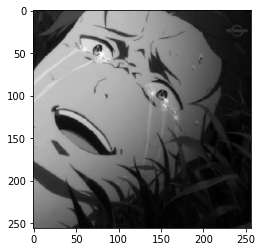

In [28]:
plt.imshow(img, cmap='gray')

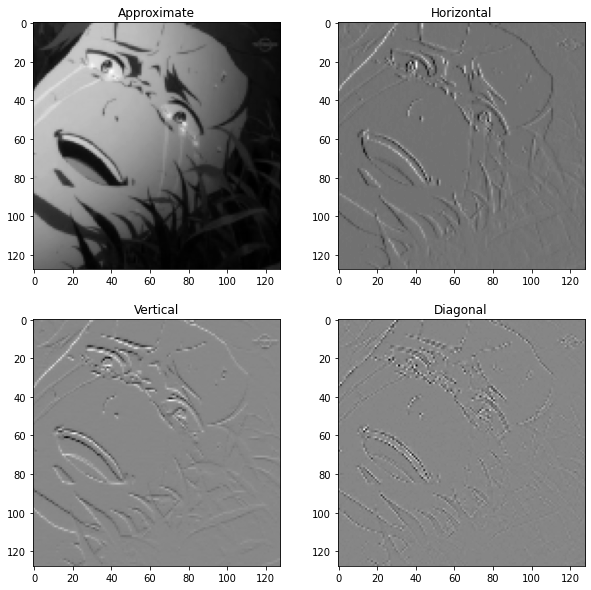

In [29]:
dwt = DWT(img, lo, hi)
dwt.preview()

In [33]:
rlo = np.array([[0.7071067812],[0.7071067812]])
rhi = np.array([[0.7071067812],[-0.7071067812]])

In [47]:
class ReverseDWT:
  def __init__(self, approximate, horizontal, vertical, diagonal, rev_kernel_lo, rev_kernel_hi):
    self.approximate = approximate
    self.horizontal = horizontal
    self.vertical = vertical
    self.diagonal = diagonal
    self.rev_kernel_lo = rev_kernel_lo
    self.rev_kernel_hi = rev_kernel_hi

  def upscale(self, img, direction):
    h, w = img.shape
    if(direction == 'row'):
      res = np.zeros([h*2, w])
      res[::2, ::] = img
      return np.array(res)
    elif(direction == 'col'):
      res = np.zeros([h, w*2])
      res[::, ::2] = img
      return np.array(res)
    else:
      print('invalid direction')
      return None

  def reversed_low_low(self):
    up = self.upscale(self.approximate, direction='col')
    filter_up_rev = self.filter(up, np.transpose(self.rev_kernel_lo))
    return filter_up_rev

  def reversed_low_high(self):
    up = self.upscale(self.horizontal, direction='col')
    filter_up_rev = self.filter(up, np.transpose(self.rev_kernel_hi))
    return filter_up_rev

  def reversed_high_low(self):
    up = self.upscale(self.vertical, direction='col')
    filter_up_rev = self.filter(up, np.transpose(self.rev_kernel_lo))
    return filter_up_rev

  def reversed_high_high(self):
    up = self.upscale(self.diagonal, direction='col')
    filter_up_rev = self.filter(up, np.transpose(self.rev_kernel_hi))
    return filter_up_rev

  def reversed_low(self):
    join = self.reversed_low_low() + self.reversed_low_high()
    up_join = self.upscale(join, direction='row')
    up_filter = self.filter(up_join, self.rev_kernel_lo)
    return up_filter

  def reversed_high(self):
    join = self.reversed_high_low() + self.reversed_high_high()
    up_join = self.upscale(join, direction='row')
    up_filter = self.filter(up_join, self.rev_kernel_hi)
    return up_filter

  def reversed_full(self):
    return self.reversed_low() + self.reversed_high()

  def filter(self, image, kernel):
    img = image
    h_img, w_img = img.shape
    h_ker, w_ker = kernel.shape

    h_center = int((h_ker - 1)/2)
    w_center = int((w_ker - 1)/2)

    h_res = h_img
    w_res = w_img
    l_pad = w_center
    r_pad = w_ker - w_center
    t_pad = h_center
    b_pad = h_ker - h_center
    img = np.pad(img, ((l_pad, r_pad), (t_pad, b_pad)), mode='edge')

    result = np.zeros([h_res, w_res])

    for i in range(h_res):
      for j in range(w_res):
        dot = 0
        for k in range(h_ker):
          for l in range(w_ker):
            dot += img[i+k, j+l] * kernel[k, l]
        result[i, j] = dot

    return result


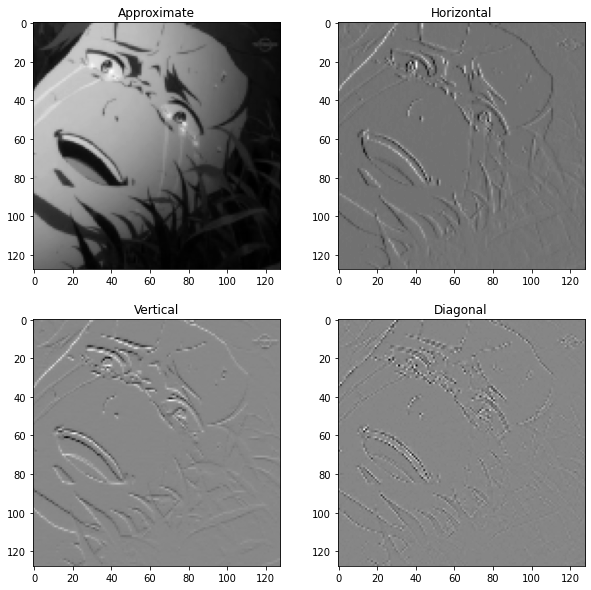

In [42]:
approximate = dwt.approximate()
horizontal = dwt.horizontal()
vertical = dwt.vertical()
diagonal = dwt.diagonal()

plt.figure(figsize=(10,10))
plt.yticks = []
plt.xticks = []

plt.subplot(2,2,1)
plt.title('Approximate')
plt.imshow(approximate, cmap='gray')

plt.subplot(2,2,2)
plt.title('Horizontal')
plt.imshow(horizontal, cmap='gray')


plt.subplot(2,2,3)
plt.title('Vertical')
plt.imshow(vertical, cmap='gray')


plt.subplot(2,2,4)
plt.title('Diagonal')
plt.imshow(diagonal, cmap='gray')

In [48]:
reverseDWT = ReverseDWT(approximate, horizontal, vertical, diagonal, rlo, rhi)
reversed = reverseDWT.reversed_full()


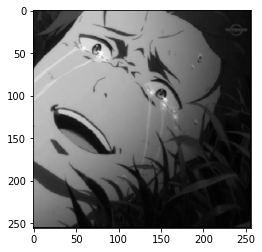

In [49]:
plt.imshow(reversed, cmap='gray')

0.0